# Модель прогнозирования стоимости жилья для агентства недвижимости

In [1]:
import pandas as pd
import numpy as np
import json
import re
import sys
import random

#импортируем инструменты экспресс анализа данных
import sweetviz as sv
from ydata_profiling import ProfileReport

# импортируем библиотеки для визуализации и отключаем уведомления
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# импортируем модели и метрики для моделей
import optuna
import time
from itertools import chain
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn import metrics
from tqdm.notebook import tqdm
from category_encoders import TargetEncoder, CatBoostEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

#### 1.2 Определение констант

In [2]:
# фиксируем RANDOM_SEED для воспроизводимости эксперимента
RANDOM_SEED = 42
# задачаем размер тестовой выборки
TEST_SIZE = 0.2

In [3]:
# зафиксируем версии пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [4]:
# создадим универсальную функцию для определения выбросов при обработке данных, подробнее про поиск выбросов с помощью iqr https://www.codecamp.ru/blog/remove-outliers-python/

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

# методом Z-оценки - https://wedx.ru/obnaruzhenie-anomalij-vyyavlenie-vybrosov-v-dannyh.html#:~:text=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%20Z%2DScore%20%E2%80%94%20%D1%8D%D1%82%D0%BE%20%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9,%D0%BA%D0%BE%D0%BB%D0%B8%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%BE%20%D1%81%D1%82%D0%B0%D0%BD%D0%B4%D0%B0%D1%80%D1%82%D0%BD%D1%8B%D1%85%20%D0%BE%D1%82%D0%BA%D0%BB%D0%BE%D0%BD%D0%B5%D0%BD%D0%B8%D0%B9%2C%20%D1%81%D1%87%D0%B8%D1%82%D0%B0%D1%8E%D1%82%D1%81%D1%8F%20%D0%B2%D1%8B%D0%B1%D1%80%D0%BE%D1%81%D0%B0%D0%BC%D0%B8

def outliers_z_score(ys, threshold=3):
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores = [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

#### 1.4 Подгрузка данных

In [5]:
data = pd.read_csv('D:\IDE\диплом\diplom\project\data3.csv')
data.drop('Unnamed: 0', axis = 1, inplace = True)

### <center> 5. Подготовка данных для обучения модели и обучение моделей

In [6]:
# Составим список категориальных признаков:
cat_features = ['status','property_type', 'fireplace', 'city', 'state', 'private_pool', 'remodeling', 'parking']
 
# Составим список числовых признаков:
num_features = ['sqft', 'target', 'number_of_schools', 'average_school_rating', 'average_distance_to_school', 'year_house_builtt', 'baths']

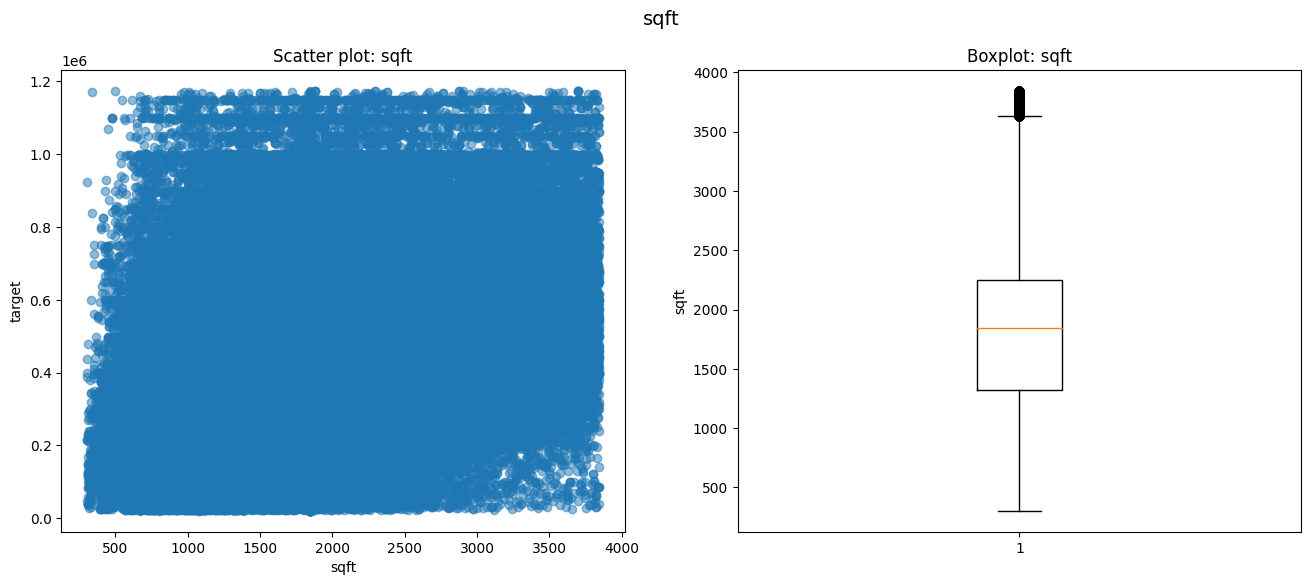

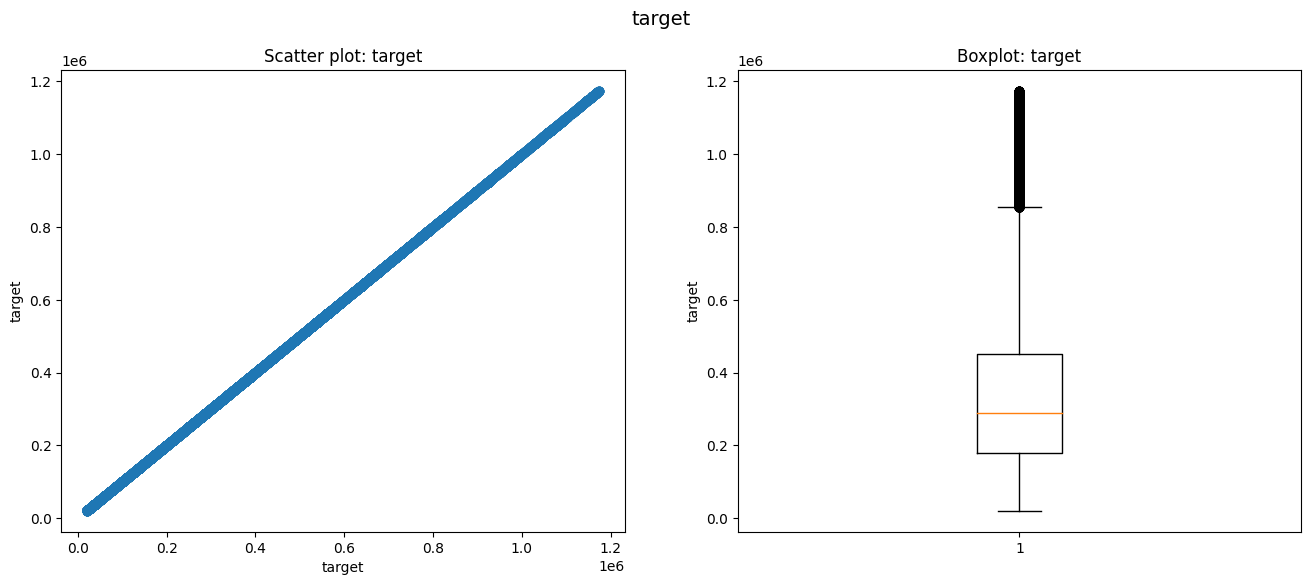

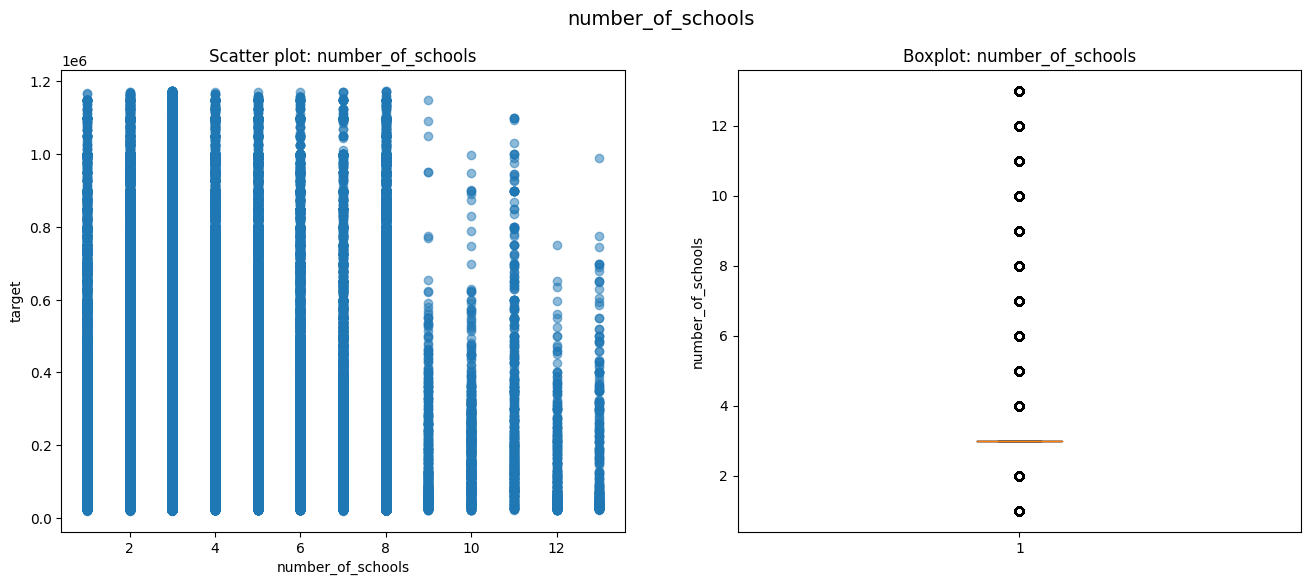

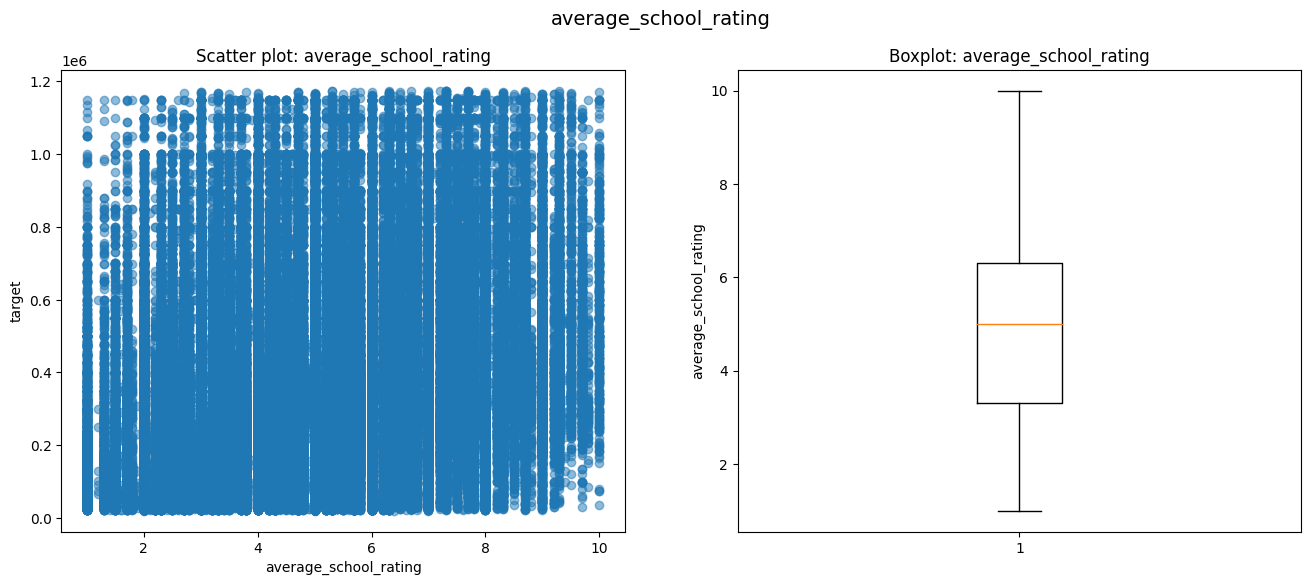

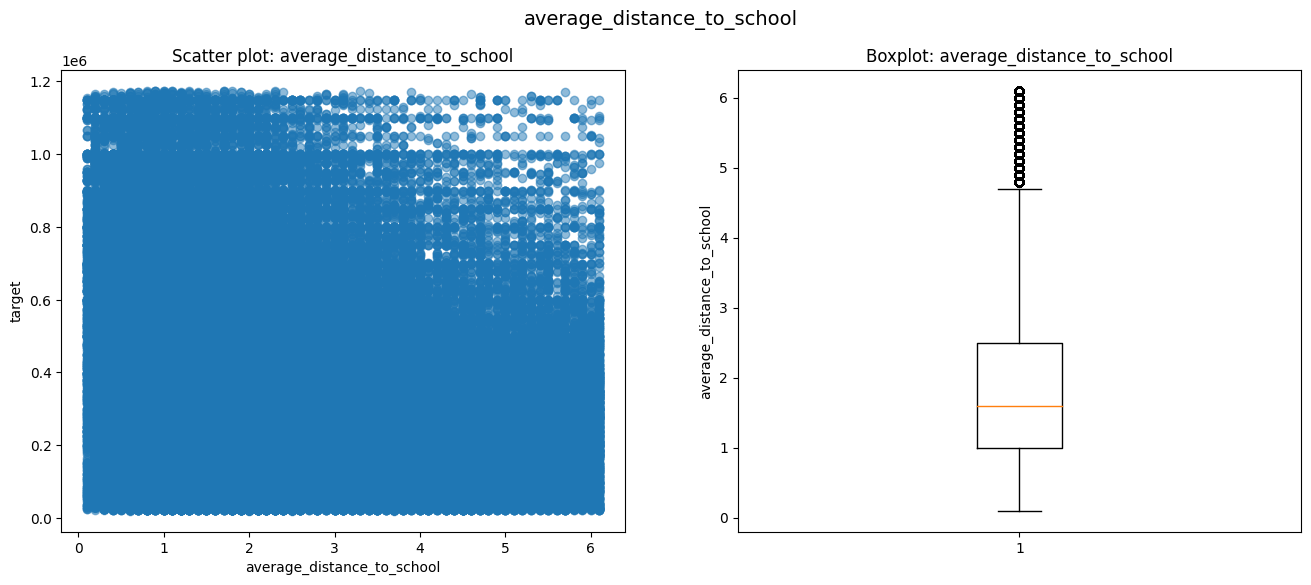

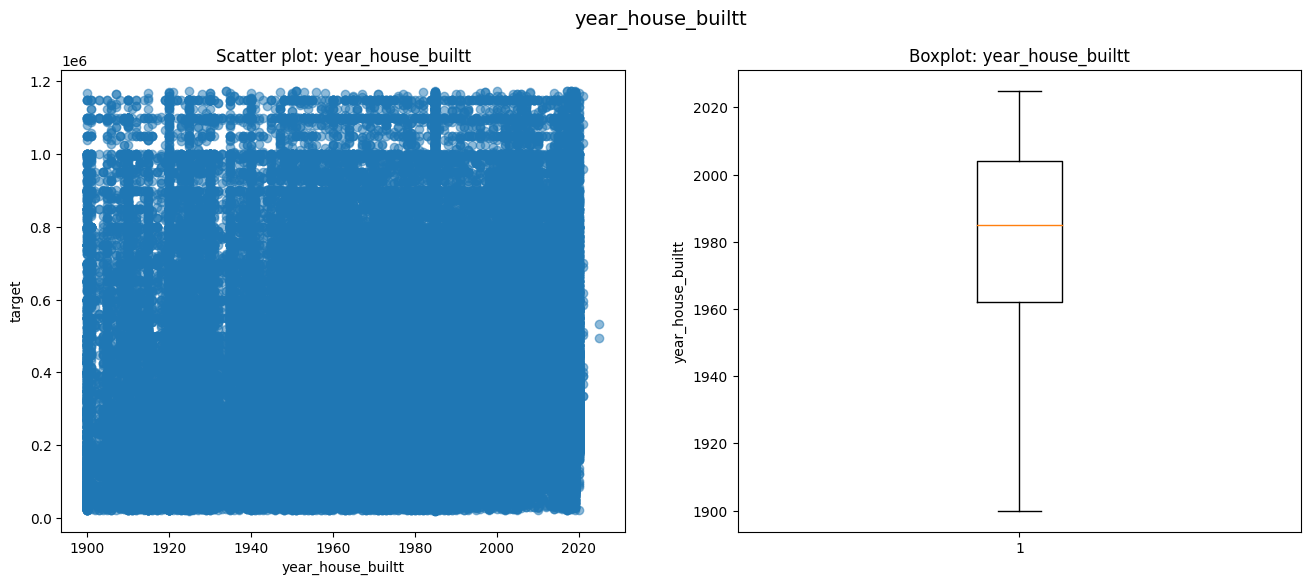

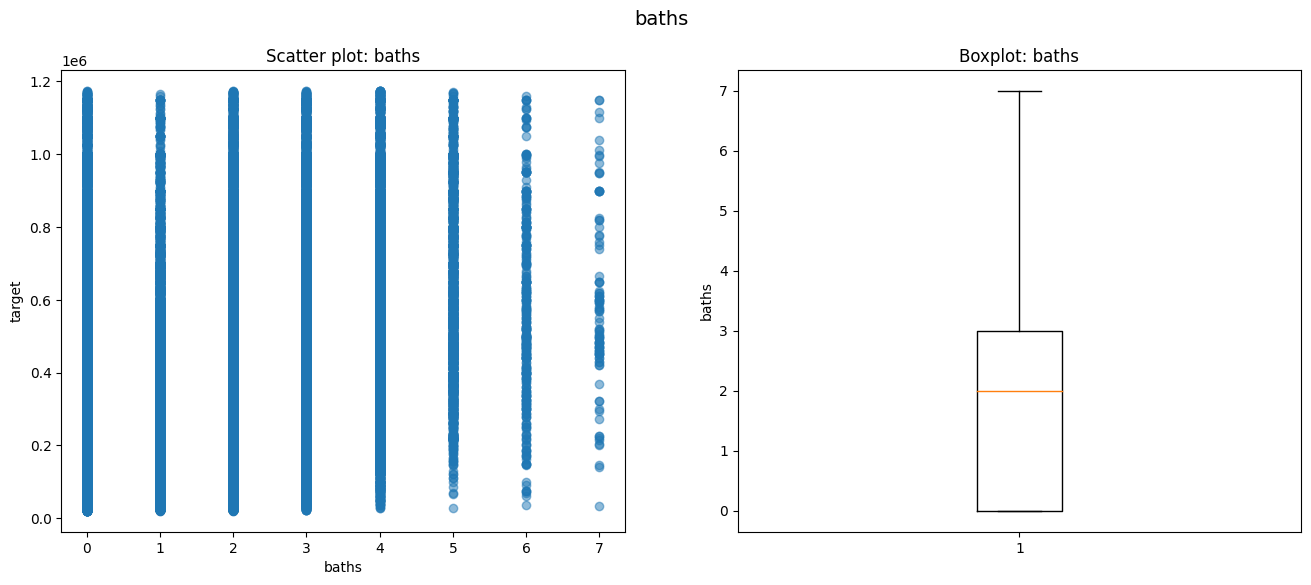

In [7]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(data[feature], data['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(data[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

> ***Выводы***

Выбросов не выявлено при оценке признаков и целевым признаком. Данные очищенны качественно. 

Ранг матрицы корреляций: 7
Определитель матрицы корреляций: 0.4721640


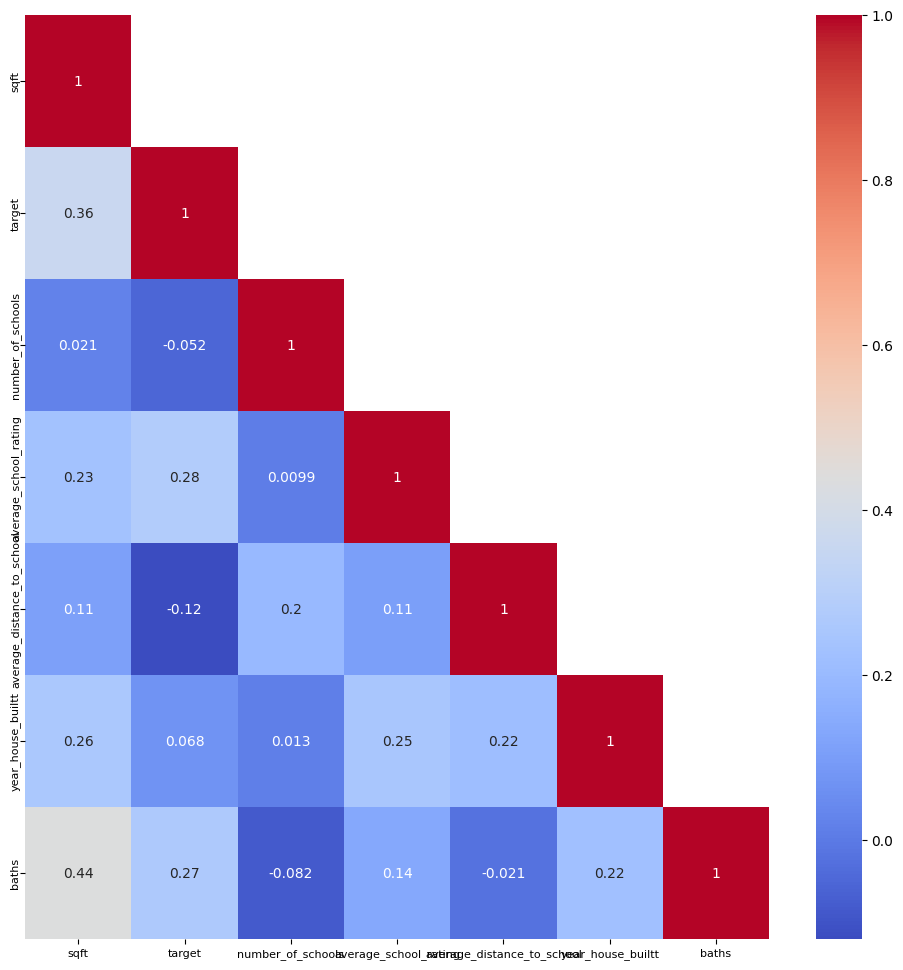

In [8]:
# Проверяем на мультиколлинеарность и корреляцию числовых признаков между собой и с главным признаком "target":
# строим матрицу корреляций
corr_matrix = np.corrcoef(data[num_features], rowvar=False)
print('Ранг матрицы корреляций:', np.linalg.matrix_rank(corr_matrix))
print('Определитель матрицы корреляций: {:.7f}'.format(np.linalg.det(corr_matrix)))

# формируем треугольник матрицы корреляций
corr_matrix_tril = np.tril(corr_matrix)
corr_matrix_tril[corr_matrix_tril == 0] = np.nan

# строим тепловую карту
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix_tril, annot=True, cmap='coolwarm', mask=np.isnan(corr_matrix_tril))
# добавляем подписи столбцов на тепловой карте
plt.xticks(np.arange(len(data[num_features].columns))+0.5, data[num_features].columns, rotation=0, ha='center', fontsize=8)
plt.yticks(np.arange(len(data[num_features].columns))+0.5, data[num_features].columns, ha='center', fontsize=8, va='center', rotation=90)
plt.show()

Высокой значений корреляции не обнаружено

In [9]:
def preproc_data(df_ohe):
    
    df_ohe = df_ohe.copy()
    # переведем признак baths в категориальный
    df_ohe['baths'] = df_ohe['baths'].astype(str)
    df_ohe['year_house_builtt'] = df_ohe['year_house_builtt'].astype(str)
    # Нормализация и логорифмирование данных
    #scaler = MinMaxScaler()
    for column in ['sqft', 'target', 'number_of_schools', 'average_school_rating', 'average_distance_to_school']:
        df_ohe[column] = df_ohe[column].apply(lambda x: abs(x))
        constant = 1e-6
        df_ohe[column] = np.log(df_ohe[column] + constant)

        # OHE кодирование категориальных признаков
 
    ohe_status = OneHotEncoder(sparse=False)
    status_ohe = ohe_status.fit_transform(df_ohe['status'].values.reshape(-1,1))
    df_ohe = df_ohe.join(pd.DataFrame(status_ohe, columns=['status_' + str(cat) for cat in ohe_status.categories_[0]]))

    ohe_property_type = OneHotEncoder(sparse=False)
    property_type_ohe = ohe_property_type.fit_transform(df_ohe['property_type'].values.reshape(-1,1))
    df_ohe = df_ohe.join(pd.DataFrame(property_type_ohe, columns=['property_type_' + str(cat) for cat in ohe_property_type.categories_[0]]))
    
    ohe_baths = OneHotEncoder(sparse=False)
    baths_ohe = ohe_baths.fit_transform(df_ohe['baths'].values.reshape(-1,1))
    df_ohe = df_ohe.join(pd.DataFrame(baths_ohe, columns=['baths_' + str(cat) for cat in ohe_baths.categories_[0]]))
    
    ohe_fireplace = OneHotEncoder(sparse=False)
    fireplace_ohe = ohe_fireplace.fit_transform(df_ohe['fireplace'].values.reshape(-1,1))
    df_ohe = df_ohe.join(pd.DataFrame(fireplace_ohe, columns=['fireplace_' + str(cat) for cat in ohe_fireplace.categories_[0]]))
    
    ohe_city = OneHotEncoder(sparse=False)
    city_ohe = ohe_city.fit_transform(df_ohe['city'].values.reshape(-1,1))
    df_ohe = df_ohe.join(pd.DataFrame(city_ohe, columns=['city_' + str(cat) for cat in ohe_city.categories_[0]]))
    
    ohe_state = OneHotEncoder(sparse=False)
    state_ohe = ohe_state.fit_transform(df_ohe['state'].values.reshape(-1,1))
    df_ohe = df_ohe.join(pd.DataFrame(state_ohe, columns=['state_' + str(cat) for cat in ohe_state.categories_[0]]))
    
    ohe_private_pool = OneHotEncoder(sparse=False)
    private_pool_ohe = ohe_private_pool.fit_transform(df_ohe['private_pool'].values.reshape(-1,1))
    df_ohe = df_ohe.join(pd.DataFrame(private_pool_ohe, columns=['private_pool_' + str(cat) for cat in ohe_private_pool.categories_[0]]))
    
    ohe_remodeling = OneHotEncoder(sparse=False)
    remodeling_ohe = ohe_remodeling.fit_transform(df_ohe['remodeling'].values.reshape(-1,1))
    df_ohe = df_ohe.join(pd.DataFrame(remodeling_ohe, columns=['remodeling_' + str(cat) for cat in ohe_remodeling.categories_[0]]))
    
    ohe_parking = OneHotEncoder(sparse=False)
    parking_ohe = ohe_parking.fit_transform(df_ohe['parking'].values.reshape(-1,1))
    df_ohe = df_ohe.join(pd.DataFrame(parking_ohe, columns=['parking_' + str(cat) for cat in ohe_parking.categories_[0]]))
    
    df_ohe.drop(['status', 'property_type', 'baths', 'fireplace', 'fireplace_no', 'city', 'state', 'private_pool', 'private_pool_no', 'remodeling', 'remodeling_no', 'parking'], axis=1, inplace=True)
    
    return df_ohe

In [10]:
# Запускаем и проверяем, что получилось
df_encoded = preproc_data(data)
df_encoded.sample(10)

,sqft,target,year_house_builtt,average_school_rating,number_of_schools,average_distance_to_school,status_active,status_auction,status_for sale,status_foreclosure,...,state_other,private_pool_yes,remodeling_yes,parking_1 space,parking_2 spaces,parking_attached garage,parking_detached garage,parking_more_than_2_spaces,parking_no_info,parking_other
165671,7.416980,13.560618,2018.0,1.308333,1.098613,0.095311,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
166380,6.927558,12.072541,1997.0,1.791760,1.098613,0.641854,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
223646,7.632401,12.487108,2016.0,1.458615,1.098613,1.386295,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
234745,7.651120,13.109015,1985.0,1.791760,2.079442,0.587787,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
185220,7.189168,13.005830,2001.0,1.609438,0.693148,0.641854,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5360,7.996317,12.254863,1998.0,1.791760,1.098613,-0.356674,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
172433,6.613384,12.517227,2005.0,1.791760,0.693148,0.788458,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
31327,7.549609,11.755872,1924.0,1.435085,2.079442,0.587787,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
156686,7.580700,13.005830,2003.0,1.916923,1.609438,1.386295,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
117013,7.521318,11.677592,1930.0,1.386295,1.098613,-0.916288,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
# Разобьет датасет на тестовую, обучающею и валидацонные выборки
y = df_encoded.target.values
X = df_encoded.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

#### <center> 5.1 Наивная модель

В работе будет использовать следующие метрики:

MAE (Средняя абсолютная ошибка, Mean Absolute Error) - это мера ошибки, вычисленная как среднее значение абсолютных значений ошибок. Меньшие значения MAE указывают на лучшую точность модели.

MSE (Среднеквадратическая ошибка, Mean Squared Error) - измеряет среднее квадратов ошибок, то есть среднеквадратичную разницу между оценочными значениями и фактическим значением. Чем ниже значение, тем более точными считаются предсказания

MAPE (Средняя абсолютная процентная ошибка, Mean absolute percentage error) - средняя разница между прогнозируемым значением и фактическим значением. Чем ниже значение, тем более точными считаются предсказания

R^2 (коэффициент детерминации) - статистическая мера, которая показывает, насколько хорошо вариации зависимой переменной объясняются моделью. Значения R^2 находятся в диапазоне от -∞ до 1. Чем ближе значение R^2 к 1, тем лучше модель объясняет зависимость между переменными. 


Создадим модель на основании года строительства недвижимости

In [13]:
# Наивная модель
class NaiveModel:
    def __init__(self):
        self.means = None

    def fit(self, X, y):
        X_df = pd.DataFrame(X, columns=['year_house_builtt'])
        y_df = pd.DataFrame(y, columns=['target'])
        df = pd.concat([X_df, y_df], axis=1)
        self.means = df.groupby(['year_house_builtt'])['target'].mean().reset_index()

    def predict(self, X):
        X = pd.DataFrame(X, columns=['year_house_builtt']).copy()
        X['mean'] = np.nan
        for idx, row in self.means.iterrows():
            X.loc[(X['year_house_builtt'] == row['year_house_builtt']), 'mean'] = row['target']
        
        X['mean'].fillna(X['mean'].mean(), inplace=True)
        return X['mean'].to_numpy()

naive_model = NaiveModel()
naive_model.fit(X_train, y_train)
y_pred_train = naive_model.predict(X_train)
y_pred_test = naive_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_train = metrics.mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = metrics.mean_absolute_percentage_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train MAPE: {mape_train:.2f}")
print(f"Test MAPE: {mape_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.58
Test MSE: 0.58
Train MAE: 0.59
Test MAE: 0.59
Train MAPE: 0.05
Test MAPE: 0.05
Train R2: -0.00
Test R2: -0.00


В данном случае, как для обучающей, так и для тестовой выборки MSE составляет 0.58.  MAE для наивной модели: 0.59 для обучающей и 0.58 для тестовой выборки. Значения MSE и MAE, как для обучающей, так и для тестовой выборок, практически одинаковы, что демонстрирует схожую производительность на обеих выборках и стабильную предсказательную способность модели без признаков переобучения.

Значение метрики MAPE составляет 5% для обучающей и тестовой выборок, возьмем его за основу для сравнения с качеством предсказания других моделей 

Коэффициент детерминации (R2) близок к нулю, что свидетельствует о низкой предсказательной способности модели.

#### <center> 5.2 DummyRegressor

In [14]:
# Создаем экземпляр модели DummyRegressor
rf_regressor = DummyRegressor(strategy="mean")

# Обучаем модель на обучающих данных
rf_regressor.fit(X_train, y_train)

# Предсказания на обучающих и тестовых данных
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Вычисляем метрики
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
mape_train = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train MAPE: {mape_train:.2f}")
print(f"Test MAPE: {mape_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.58
Test MSE: 0.58
Train MAE: 0.59
Test MAE: 0.59
Train MAPE: 0.05
Test MAPE: 0.05
Train R2: 0.00
Test R2: -0.00


Значения метрик аналогичны наивной модели

#### <center> 5.3 Линейная регрессия

In [254]:
# создаём модель линейной регрессии
model = LinearRegression(fit_intercept=False)

# вычисляем коэффициенты регрессии
model.fit(X_train, y_train)

# делаем предсказания с помощью модели
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# вычисляем требуемые метрики
mse_train = metrics.mean_squared_error(y_train, y_train_pred)
mse_test = metrics.mean_squared_error(y_test, y_test_pred)
mae_train = metrics.mean_absolute_error(y_train, y_train_pred)
mape_test = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
mape_train = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
mae_test = metrics.mean_absolute_error(y_test, y_test_pred)
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test = metrics.r2_score(y_test, y_test_pred)

# выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train MAPE: {mape_train:.2f}")
print(f"Test MAPE: {mape_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.31
Test MSE: 0.31
Train MAE: 0.41
Test MAE: 0.40
Train MAPE: 0.03
Test MAPE: 0.03
Train R2: 0.47
Test R2: 0.47


Наблюдаем значительное улучшение в начениях метрик в сравнении с наивной моделью 

Для линейной регрессии как для обучающей, так и для тестовой выборки MSE составляет 0.31. Низкие значения MSE указывают на более точные предсказания модели.

MAE составляет 0.41 для обучающей и 0.40 для тестовой выборки. Низкие значения MAE также говорят о хорошей точности предсказания.

Значение MAPE свидетельствует о разнице в истинных и предсказанны значениях в 3%.

Коэффициент детерминации (R2) В данном случае R2 составляет 0.47 как для обучающей, так и для тестовой выборки, что означает, что модель объясняет 47% дисперсии зависимой переменной.

Схожие результаты метрик для обучающей и тестовой выборок свидетельствуют об отсутствии переобучения, но показатели метрик попробуем улучшить при использовании других моделей

#### <center> 5.4 Случайный лес (RandomForestRegressor)

In [255]:
# Создаем экземпляр модели RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=RANDOM_SEED)

# Обучаем модель на обучающих данных
rf_regressor.fit(X_train, y_train)

# Предсказания на обучающих и тестовых данных
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Вычисляем метрики
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
mape_train = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train MAPE: {mape_train:.2f}")
print(f"Test MAPE: {mape_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.04
Test MSE: 0.17
Train MAE: 0.11
Test MAE: 0.27
Train MAPE: 0.01
Test MAPE: 0.02
Train R2: 0.93
Test R2: 0.70


Для случайного леса значения MSE для обучающей выборки составляет 0.04, для тестовой выборки - 0.17, MAE - 0.11 для обучающей выборки и 0.27 для тестовой выборки соответственноб что указывает на переобучение модели.

Для MAPE разница в значениях метрик для обучающей и тестовой выборок составляет 1%.

Коэффициент детерминации равен 0.93 для обучающей выборки и 0.70 для тестовой выборки, что свидетельствует о достаточно неплохой прогностической способности модели, но также указывает на ее переобучение.

Наблюдаем значительное улучшение в начениях метрик в сравнении с наивной моделью 

В целом, результаты для случайного леса демонстрируют хорошую производительность на обучающей выборке, но на тестовой выборке результаты хуже, что свидетельствует о переобучении.

In [297]:
# Параметры можно подобрать лучше - но не хвататет времени подбора оптимальных гиперпараметров. Приложила функцию, что умею это делать 
# def objective(trial):
#     rf_model = RandomForestRegressor(
#         n_estimators = trial.suggest_int('n_estimators', 100, 500),
#         min_samples_split = trial.suggest_int('min_samples_split', 3, 10),
#         min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10),
#         max_features = trial.suggest_categorical("max_features", ["auto", "sqrt"]),
#         max_depth = trial.suggest_int('max_depth', 3, 10),
#         bootstrap = True,
#         random_state = RANDOM_SEED
#     )
    
#     allmse = []
    
#     for i in range(1, 10):   
#         rf_model.fit(X_train, y_train)     
#         y_pred = rf_model.predict(X_test)
#         mape = mean_absolute_percentage_error(y_test, y_pred)
#         allmse.append(mse)       
#     return np.mean(allmse)


# def optuna_tune():
#     t0 = time.perf_counter()
#     num_trials = 30 
#     sampler = optuna.samplers.TPESampler(seed=1)    
#     study = optuna.create_study(sampler=sampler, direction='minimize')
#     study.optimize(objective, n_trials=num_trials)    
#     best_params = study.best_params
#     print(f'best params: {study.best_params}')
#     print(f'best mean value: {study.best_value}')      
#     print(f'elapse: {time.perf_counter() - t0:0.1f}s')

# optuna_tune()

#### <center> 5.5 CatBoostRegressor

In [ ]:
def log_data(df_input):
    
    df_output = df_input.copy()
    # переведем признак год в категориальный
    df_output['year_house_builtt'] = df_output['year_house_builtt'].astype(str)
    # Нормализация данных и логорифмирование
    #scaler = MinMaxScaler()
    for column in ['sqft', 'target', 'number_of_schools', 'average_school_rating', 'average_distance_to_school', 'baths']:
        # Логорифмирование
        df_output[column] = df_output[column].apply(lambda x: abs(x))
        constant = 1e-6
        df_output[column] = np.log(df_output[column] + constant)
    return df_output

In [ ]:
# Запускаем и проверяем, что получилось
df_log = log_data(data)
df_log.sample(5)

In [ ]:
y = df_log.target.values
X = df_log.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [272]:
param_grid = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
}
cb_model = CatBoostRegressor(random_seed=RANDOM_SEED, silent=True)
grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train, cat_features=cat_features)
best_params = grid_search.best_params_
best_cb_model = CatBoostRegressor(iterations=best_params['iterations'], learning_rate=best_params['learning_rate'], depth=best_params['depth'], l2_leaf_reg=best_params['l2_leaf_reg'], random_seed=RANDOM_SEED, silent=True)
best_cb_model.fit(X_train, y_train, cat_features=cat_features)

y_train_pred = best_cb_model.predict(X_train)
y_test_pred = best_cb_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train MAPE: {mape_train:.2f}")
print(f"Test MAPE: {mape_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Train MSE: 0.18
Test MSE: 0.19
Train MAE: 0.29
Test MAE: 0.30
Train MAPE: 0.02
Test MAPE: 0.02
Train R2: 0.69
Test R2: 0.67


Наблюдаем значительное улучшение в начениях метрик в сравнении с наивной моделью 

В целом, метрики для модели CatBoostRegressor в сравнении со случайным лесом имеют более низкие показатели для обучающей выборки, для тестовой выборки - эти различия минимальны.

Данная модель показывает более стабильный результат, переобучение отсутствует, показатели точности предсказания достаточно высокие.
В связи с этим будем считать модель CatBoostRegressor наилучшей из рассмотренных

In [17]:
#Для наиболее наглядного представления результатов предсказания составим сводную таблицу
metrics = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train MAPE', 'Test MAPE', 'Train R2', 'Test R2'],
        'NaiveModel': [0.58, 0.58, 0.59, 0.59, 0.05, 0.05, -0.00, -0.00],
        'DummyRegressor': [0.58, 0.58, 0.59, 0.59, 0.05, 0.05, -0.00, -0.00],
        'LinearRegression': [0.31, 0.31, 0.41, 0.40, 0.03, 0.03, 0.47, 0.47],
        'RandomForestRegressor': [0.04, 0.17, 0.11, 0.27, 0.01, 0.02, 0.93, 0.70],
        'CatBoostRegressor':[0.18, 0.19, 0.29, 0.30, 0.02, 0.02, 0.69, 0.67]}

df_metric = pd.DataFrame(metrics)
df_metric

,Metric,NaiveModel,DummyRegressor,LinearRegression,RandomForestRegressor,CatBoostRegressor
0,Train MSE,0.58,0.58,0.31,0.04,0.18
1,Test MSE,0.58,0.58,0.31,0.17,0.19
2,Train MAE,0.59,0.59,0.41,0.11,0.29
3,Test MAE,0.59,0.59,0.40,0.27,0.30
4,Train MAPE,0.05,0.05,0.03,0.01,0.02
5,Test MAPE,0.05,0.05,0.03,0.02,0.02
6,Train R2,-0.00,-0.00,0.47,0.93,0.69
7,Test R2,-0.00,-0.00,0.47,0.70,0.67


In [277]:
# Сохранение выбранной обученной модели в файл pickle
import pickle
with open('D:\IDE\диплом\диплом_итог\web\app\models\best_cb_model.pkl', 'wb') as f:
    pickle.dump(best_cb_model, f)